In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Information about device
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

use_cuda = torch.cuda.is_available()
print(use_cuda)
# Set proper device based on cuda availability
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU
True
Torch device selected:  cuda


In [3]:
# Construct Autoencoder
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()

        # Define layers of the autoencoder neural network
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        
        # Code (Latent Representation)
        self.fc1 = nn.Linear(256*8*8, 256)
        self.fc2 = nn.Linear(256, 256*8*8)
        
        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 3, 3, padding=1)
    
    def forward(self, X):
        
        # Encoder
        output = F.relu(self.conv1(X))
        output = F.relu(self.maxpool1(self.conv2(output)))
        output = F.relu(self.maxpool2(self.conv3(output)))
        
        # Latent Representation
        output = torch.flatten(output,1) # Flatten
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = torch.reshape(output, (-1, 256, 8, 8)) # Reshape
        
        # Decoder
        output = F.relu(self.deconv1(self.upsample1(output)))
        output = F.relu(self.deconv2(self.upsample2(output)))
        output = F.sigmoid(self.deconv3(output))
        
        return output

# Construct Autoencoder
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        # Define layers of the autoencoder neural network
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        
        # Code (Latent Representation)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 3, 3, padding=1)
    
    def forward(self, X):
        
        # Encoder
        output = F.relu(self.conv1(X))
        output = F.relu(self.maxpool1(self.conv2(output)))
        output = F.relu(self.conv3(output))
        
        # Latent Representation
        output = self.conv4(output)
        
        # Decoder
        output = F.relu(self.deconv1(output))
        output = F.relu(self.deconv2(self.upsample1(output)))
        output = F.sigmoid(self.deconv3(output))

        return output

In [4]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.transforms.functional import rgb_to_grayscale

In [26]:
# Transforms
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation(15)]
    )

test_transform = transforms.Compose(
    [transforms.ToTensor()]
    )

# Load in CIFAR10 data, splitting training and test data and applying transforms
train_data = torchvision.datasets.CIFAR10("./", train= True, transform = train_transform, download = True)
test_data = torchvision.datasets.CIFAR10("./", train= False, transform = test_transform, download = True)

# Create dataloaders for loading in data in batches of size mini_batch_size
mini_batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=mini_batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=mini_batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Define the training function
def train(model, num_epochs, optimizer, loss_func):
    # Set model to training mode
    model.train()
    losses = []

    for i in range(num_epochs):
        total_loss = 0

        for (images, _) in train_loader:
            images = images.to(device) # Push tensors to GPU
            grayscale_images = rgb_to_grayscale(images) # Convert images to grayscale
            optimizer.zero_grad() # Zero the gradients
            outputs = model(grayscale_images) # Forward pass
            loss = loss_func(outputs, images) # Calculate loss
            loss.backward() # Backpropagation
            optimizer.step() # Update weights
            total_loss += loss.item() # Accumulate loss

        # Save loss for graphing
        losses.append(total_loss / len(train_loader))
        print(f'(Epoch {i+1}) Training Loss: {total_loss / len(train_loader)} Test Loss: {test(model)}')

    return losses

# Define function for applying model to test data and returning the accuracy
def test(model):
    # Set model to evaluation mode
    model.eval()
    total_loss = 0

    # Test on test set
    for (images, _) in test_loader:
        images = images.to(device) # Push tensors to GPU
        grayscale_images = rgb_to_grayscale(images) # Convert images to grayscale
        outputs = model(grayscale_images) # Forward pass
        loss = F.mse_loss(outputs, images) # Calculate loss
        total_loss += loss.item() # Accumulate loss

    return total_loss/len(test_loader)

In [15]:
# Define hyperparameters
learning_rate = 1e-4
num_epochs = 20

In [16]:
# Create the model with FC latent code
net1 = Net1().to(device)

# Define the loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(net1.parameters(), lr=learning_rate)

# Load model, if saved parameters exist
try:
    net1.load_state_dict(torch.load("./saved models/net1.pth"))
except:
    # Perform training
    training_losses = train(net1, num_epochs, optimizer, loss_func)
    
    # Save model
    torch.save(net1.state_dict(), './saved models/net1.pth')

# Prepare model for evaluation
net1.eval()

Net1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=16384, bias=True)
  (upsample1): Upsample(scale_factor=2.0, mode='bilinear')
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample2): Upsample(scale_factor=2.0, mode='bilinear')
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [31]:
# Create the model with CNN latent code
net2 = Net2().to(device)

# Define the loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(net2.parameters(), lr=learning_rate)

# Load model, if saved parameters exist
try:
    net2.load_state_dict(torch.load("./saved models/net2.pth"))
except:
    # Perform training
    training_losses = train(net2, num_epochs, optimizer, loss_func)
    
    # Save model
    torch.save(net2.state_dict(), './saved models/net2.pth')

# Prepare model for evaluation
net2.eval()

Net2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): Upsample(scale_factor=2.0, mode='bilinear')
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [29]:
# Grab images for testing
test_images, _ = next(iter(test_loader))

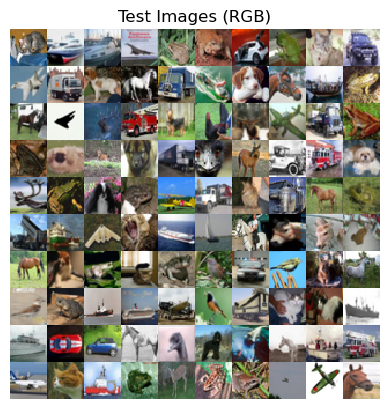

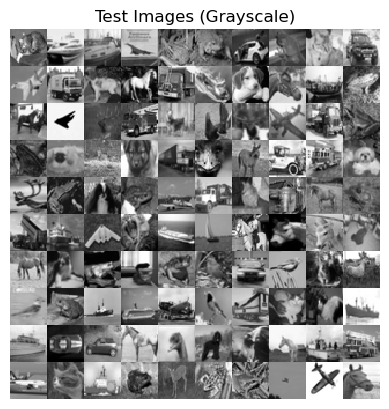

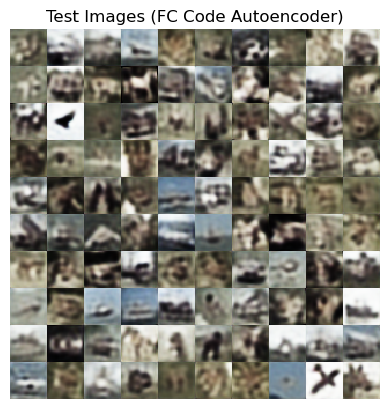

In [24]:
### Test Net1 ###

# Display images to be tested
display_test = np.array([transforms.ToPILImage()(img) for img in test_images])
display_test = display_test.reshape((10, 10, 32, 32, 3))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (RGB)')
plt.imshow(display_test, interpolation='none')
plt.show()

# Convert RGB test images into grayscale
grayscale_images = rgb_to_grayscale(test_images).to(device)

# Display images in grayscale
display_test = np.array([transforms.ToPILImage()(img) for img in grayscale_images])
display_test = display_test.reshape((10, 10, 32, 32, 1))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (Grayscale)')
plt.imshow(display_test, interpolation='none', cmap='gray')
plt.show()

# Run model on grayscale images
output = net1(grayscale_images)

# Display images after decoding
display_test = np.array([transforms.ToPILImage()(img) for img in output])
display_test = display_test.reshape((10, 10, 32, 32, 3))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (FC Code Autoencoder)')
plt.imshow(display_test, interpolation='none')
plt.show()

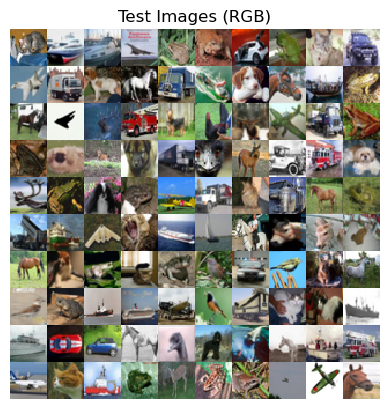

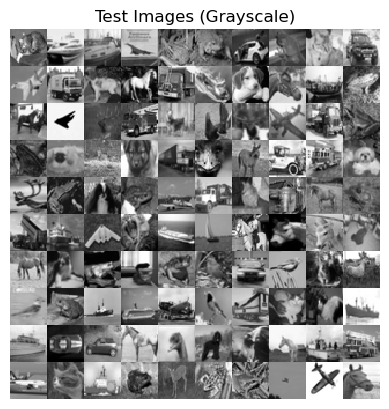

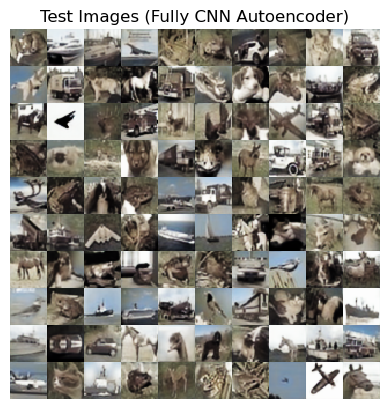

In [32]:
### Test Net2 ###

# Display images to be tested
display_test = np.array([transforms.ToPILImage()(img) for img in test_images])
display_test = display_test.reshape((10, 10, 32, 32, 3))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (RGB)')
plt.imshow(display_test, interpolation='none')
plt.show()

# Convert RGB test images into grayscale
grayscale_images = rgb_to_grayscale(test_images).to(device)

# Display images in grayscale
display_test = np.array([transforms.ToPILImage()(img) for img in grayscale_images])
display_test = display_test.reshape((10, 10, 32, 32, 1))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (Grayscale)')
plt.imshow(display_test, interpolation='none', cmap='gray')
plt.show()

# Run model on grayscale images
output = net2(grayscale_images)

# Display images after decoding
display_test = np.array([transforms.ToPILImage()(img) for img in output])
display_test = display_test.reshape((10, 10, 32, 32, 3))
display_test = np.vstack([np.hstack(i) for i in display_test])
plt.figure()
plt.axis('off')
plt.title('Test Images (Fully CNN Autoencoder)')
plt.imshow(display_test, interpolation='none')
plt.show()